In [234]:

# Which stochastic optimiser did you choose (for Task 3)?
# +
# Why did you choose this optimiser?
#
# I chose simulated annealing for a few reasons. It is stochastic so it will deal with
# the complexity of the optimised function and constraints. It is also global so it will
# search in all intervals of the function. Finally it utilizes the information obtained
# from the previous guess iteration.
#
# What constraint handling method(s) are you using and why?
#
# In case of random search I'm eliminating any result that does not meet the constraints.
# I'm using it because in case of random search the information from previous searches is
# discarded and because it's simple.
#
# In case of simulated annealing I'm adding a penalty to the score of an input. This
# penalty is added if any of the constraints is violated and is proportional to how much
# it has been violated. I'm using it to utilise information about the local search area
# once the search starts to settle in and search more locally.


In [235]:
# Imports and config

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [236]:
# Definitions

counter = []
def reset_counter():
    global counter
    counter = [0, 0, 0, 0, 0]
reset_counter()

def print_counter():
    print(f'count(f(x)): {counter[0]} times')
    for i in range(1, 5):
        print(f'count(g{i}(x)): {counter[i]} times')

def print_results(x):
    print(f'f(x): {f(x)}')
    print(f'g1(x): {g1(x)}, g2(x): {g2(x)}, g3(x): {g3(x)}, g4(x): {g4(x)}')
    print(f'x1: {x[0]}, x2: {x[1]}, x3: {x[2]}')

def f(x):
    global counter
    counter[0] += 1

    x1 = x[0]
    x2 = x[1]
    x3 = x[2]

    return pow(x1, 2) * x2 * (2 + x3)

def g1(x):
    global counter
    counter[1] += 1

    x1 = x[0]
    x2 = x[1]
    x3 = x[2]

    return 1 - (pow(x2, 3) * x3 / 71785 / pow(x1, 4))

def g2(x):
    global counter
    counter[2] += 1

    x1 = x[0]
    x2 = x[1]
    x3 = x[2]

    p1 = (4 * pow(x2, 2) - (x1 * x2)) / 12566 / (x2 * pow(x1, 3) - pow(x1, 4))
    p2 = 1 / 5108 / pow(x1, 2) - 1
    return p1 + p2

def g3(x):
    global counter
    counter[3] += 1

    x1 = x[0]
    x2 = x[1]
    x3 = x[2]

    return 1 - (140.45 * x1 / pow(x2, 2) / x3)

def g4(x):
    global counter
    counter[4] += 1

    x1 = x[0]
    x2 = x[1]
    x3 = x[2]

    return (x1 + x2) / 1.5 - 1

BOUNDS = [
    [0.05, 2],
    [0.25, 1.3],
    [2, 15]
]

In [237]:
# Helpers

g = [g1, g2, g3, g4]

def bounded_normal(loc, scale, lo_bound, hi_bound):
    r = np.random.normal(loc, scale)
    r = min(r, hi_bound)
    r = max(r, lo_bound)
    return r

In [238]:
# Random Search

def random_search(
        optimization_function,
        constraint_functions,
        input_size,
        bounds,
        limit
):
    best_x = []
    for input_index in range(0, input_size):
        best_x.append(0)

    best_fx = float('inf')

    for iteration in range(0, limit):
        x = []
        for input_index in range(0, input_size):
            x.append(
                np.random.uniform(
                    bounds[input_index][0],
                    bounds[input_index][1]))

        meets_constraints = True
        for constraint_index in range(0, len(constraint_functions)):
            if constraint_functions[constraint_index](x) > 0:
                meets_constraints = False
                break

        if meets_constraints:
            fx = optimization_function(x)
            if fx < best_fx:
                best_x = x
                best_fx = fx

    return [best_fx, best_x]

reset_counter()
[result, inputs] = random_search(
    f,
    g,
    3,
    BOUNDS,
    3000
)
print_counter()
print_results(inputs)

count(f(x)): 29 times
count(g1(x)): 3000 times
count(g2(x)): 60 times
count(g3(x)): 35 times
count(g4(x)): 29 times
f(x): 0.02156973671654861
g1(x): -0.3483820082269362, g2(x): -0.08982806863641457, g3(x): -2.6732552187451084, g4(x): -0.4649105117330138
x1: 0.06625843352827819, x2: 0.7363757988722012, x3: 4.672107099209981


In [239]:
# Simulated Annealing

PENALTY_FACTOR = 20000
SD_WIDTH = 0.125

def calculate_standard_deviations(bounds, deviation_width):
    standard_deviations = []

    for bound_index in range(0, len(bounds)):
        standard_deviations.append(
            (bounds[bound_index][1] - bounds[bound_index][0]) * deviation_width)

    return standard_deviations

def evaluate_with_penalty(
        optimization_function,
        constraint_functions,
        penalty_factor,
        x
):
    fx = optimization_function(x)

    for input_index in range(0, len(x)):
        penalty = constraint_functions[input_index](x)
        if penalty > 0:
            fx += penalty * penalty_factor

    return fx

def simulated_annealing(
        optimization_function,
        constraint_functions,
        penalty_factor,
        input_size,
        bounds,
        standard_deviation_width,
        limit
):
    standard_deviations = calculate_standard_deviations(bounds, standard_deviation_width)

    x_best = []
    for input_index in range(0, input_size):
        x_best.append(np.random.uniform(bounds[input_index][0], bounds[input_index][1]))

    fx_best = evaluate_with_penalty(
        optimization_function,
        constraint_functions,
        penalty_factor,
        x_best)

    x_center = x_best

    fx_center = fx_best

    for iteration in range(1, limit):
        x = []
        for input_index in range(0, input_size):
            x.append(
                bounded_normal(
                    x_center[input_index],
                    standard_deviations[input_index],
                    bounds[input_index][0],
                    bounds[input_index][1]))

        fx = evaluate_with_penalty(
            optimization_function,
            constraint_functions,
            penalty_factor,
            x)

        sig_fx = fx - fx_center

        if sig_fx <= 0 or np.random.uniform(0, 1) < min(np.exp(-sig_fx/limit), 1):
            x_center = x
            fx_center = fx

        if fx < fx_best:
            x_best = x
            fx_best = fx

    return [fx_best, x_best]

reset_counter()
[result, inputs] = simulated_annealing(
    f,
    g,
    PENALTY_FACTOR,
    3,
    BOUNDS,
    SD_WIDTH,
    3000
)
print_counter()
print_results(inputs)

count(f(x)): 3000 times
count(g1(x)): 3000 times
count(g2(x)): 3000 times
count(g3(x)): 3000 times
count(g4(x)): 0 times
f(x): 0.01623773710583623
g1(x): -0.03116411391583007, g2(x): -0.0677528631349511, g3(x): -3.856868254373646, g4(x): -0.5386341651763207
x1: 0.06264844445614402, x2: 0.6294003077793748, x3: 4.573217014170128


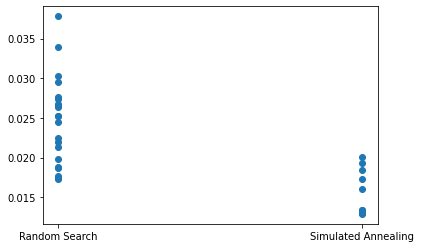

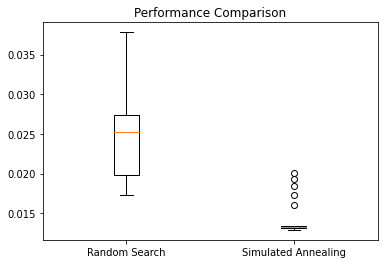

In [240]:
# Comparing performance

TEST_REPETITIONS = 21
FUNC_EVAL_LIMIT = 3000

ALGO_NAMES = ['Random Search', 'Simulated Annealing']

rs_results = []
sa_results = []
headers = []

# Performing tests

for i in range(0, TEST_REPETITIONS):
    np.random.seed(216151 * i + 21354)

    [rs_result, _] = random_search(
        f,
        g,
        3,
        BOUNDS,
        FUNC_EVAL_LIMIT
    )
    rs_results.append(rs_result)

    [sa_result, _] = simulated_annealing(
        f,
        g,
        PENALTY_FACTOR,
        3,
        BOUNDS,
        SD_WIDTH,
        FUNC_EVAL_LIMIT
    )
    sa_results.append(sa_result)

# Scatter plot

plt.scatter(
    np.concatenate((
        np.repeat(ALGO_NAMES[0], len(rs_results)),
        np.repeat(ALGO_NAMES[1], len(sa_results))
    )),
    np.concatenate((rs_results, sa_results))
)

# Box plot

fig1, ax1 = plt.subplots()
ax1.set_title('Performance Comparison')
ax1.boxplot(
    [rs_results, sa_results],
    labels=ALGO_NAMES,
    autorange=True)
plt.show()


# The charts show that simulated annealing with well tweaked hyper-parameters achieves
# significantly better results than random search given the same number of function evaluations.
# This is evidenced by the median, 25th percentile, 75th percentile and mean all being lower
# for simulated annealing.
